# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости и установить корректные параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и посмотрим на общую информацию. 

In [1]:
### Importing Pandas, Matplotlib and Numpy for future use, plus opening the dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import Counter
data = pd.read_csv ('real_estate_data.csv', sep='\t')

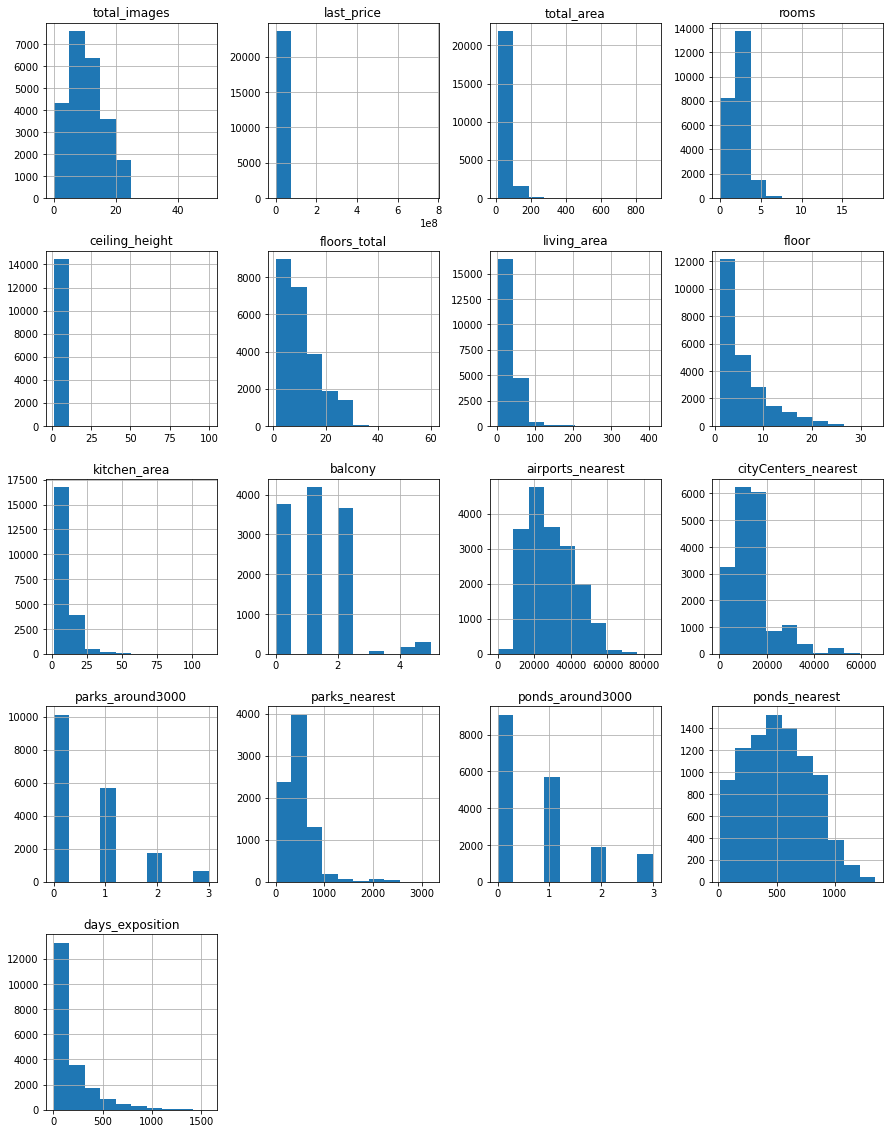

In [2]:
### building the general histogram view to see the overall picture of the data
data.hist(figsize=(15, 20));

#### Промежуточный вывод по начальным данным:
    
На первый взгляд ничего сильно аномального в данных нет. Следует обратить внимание более подробно на следующие моменты:

 - данные по комнатам, так как там есть нулевые значения судя по графику
 - данные по жилой площади, так как там есть нулевые значения судя по графику
 - данные по расстоянию до центра города или аэропорта, так как там тоже есть нулевые значения, что странно. Особенно для аэропорта.
 - данные по сроку продажи объекта - также много значений около 0 и следует обратить вниманине нет ли подозрительно быстрых продаж. Недвижемость это не шоколадка и вряд ли её покупают за 1 день.
 
В предобраюотке данных мы подробнее остановимся на этих и других моментах.

### Предобработка данных

Для начала знакомимся с датасетом, смотрим с чем нам предстоит работать и приводим данные в порядок.

In [3]:
### checking where do we have missing data and how much we are missing. Also the type of the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Работаем с пропущенными данными:

##### Столбец 'locality_name'

Так как основным параметром недвижимости является месторасположние и наличие этих данных критично для анализа, то первым делом оценим, сколько строк у нас имеют незаполненное местоположение:

In [4]:
### checking how many NaN we have in the 'locality_name' column.
len(data.loc[data['locality_name'].isna()])

49

Это всего 0,2% от всего датасета. К сожалению, мы не имеем возможности восстановить эти данные по остальным. Можно бы попробовать отталкиваться от расстояния до аэропорта, но так как мы не знаем какие аэропорты ближайшие, то это нелогично.  С учётом всего этого - отбросим их.

In [5]:
### droping the rows in the dataset where ´locality_name´ is unknown (NaN)
data = data.dropna(subset=['locality_name'])

##### Столбец 'is_apartment'
---
Теперь пройдёмся по очевидным вещам. Таким как, например, столбец 'is_apartment'. Для него пропущенные данные скорее всего означают, что данная недвижимость всё же не апартаменты, так как иначе это бы явно было это указано. Логично предположить, что все NaN следует заменить на False.

In [6]:
### checking what kind of data is in this column to understand what kind of missing data we have
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [7]:
### replacing all NaN with False
data['is_apartment'].fillna(False, inplace=True)

##### Столбец 'balcony'
Теперь сделаем то же самое для столбца 'balcony'. В нём тоже можно сказать, что пропущенное значение скорее всего означает 0 балконов.

In [8]:
### if cell in 'balcony' is NaN - replace it to 0
data['balcony'].fillna(0, inplace=True)

##### Столбцы 'parks_around3000' и 'ponds_around3000'

Приведём немного в порядок столбцы 'parks_around3000' и 'ponds_around3000'. Так как скорее пропуски в данных столбцах тоже означают, что ни парков, ни прудов нет в наличии в районе 3-х км от недвижимости и просто поленились поставить 0, то мы можем сделать это за тех, кто пропустил. Однако сначала и для парков и для прудов проверяем, что нет аномалий в данных при который есть пропуск в данных по количеству прудов\парков в радиусе 3-х км, но при этом есть данные о расстоянии о них.

In [9]:
### checking that all NaNs in 'parks_around3000' colums do not have corresponding valid data in 'parks_nearest'. 
data.query('parks_around3000.isnull() and parks_nearest.notnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [10]:
### All NaNs in 'parks_around3000' are changed to 0's
data['parks_around3000'].fillna(0, inplace=True)

In [11]:
### checking that all NaNs in 'ponds_around3000' colums do not have any valid data in 'ponds_nearest'.
data.query('ponds_around3000.isnull() and ponds_nearest.notnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [12]:
### All NaNs in 'ponds_around3000' are changed to 0's
data['ponds_around3000'].fillna(0, inplace=True)

##### Столбец 'kitchen_area'

Для размера кухни вероятна зависимость от общей площади квартиры или от количества комнат в жилье. Для начала проверим корреляцию данного параметра с указанными нами характеристиками жилья. 

In [13]:
### checking correlation between kitchen_area and total_area
data['kitchen_area'].corr(data['total_area'])

0.6088787817469404

In [14]:
### checking correlation between kitchen_area and rooms
data['kitchen_area'].corr(data['rooms'])

0.2705847536227906

Из этого можно сделать вывод, что размеры кухни больше зависят от общей площади квартиры, нежели чем от количества комнат. Это представляется логичным. Так что далее мы выясним какие варианты площади недвижимости есть в массиве данных и для каждого варианта заполним пропуски в данных о площади кухни на основании медианного значения площадей кухонь в недвижимости данной площади.

In [15]:
### going through the dataset and for any unique item in 'total_area' we are calculating the median of the 'kitchen_area'
### cells where data is present and filling the empty cells within this selection with this median value.
for item in data['total_area'].unique():
    data.loc[(data['total_area'] == item) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[data['total_area'] == item, 'kitchen_area'].median()
    ### ignoring warnings about inability to make action because of the missing data - not important for us.
    warnings.filterwarnings("ignore")

Ошибки, которые мы видим, не являются ошибками как таковыми, а просто предупреждениями о том, что в какой-то из групп нет ни одного значения и заполнить kitchen_area - нечем. Но что есть, то есть. Однако так как площадь кухни является значимой характеристикой недвижимости и количество строк, которые мы не смогли заполнить составляет менее 1%, то мы можем их также отбросить для чистоты анализа:

In [16]:
### dropping rows where data in 'kitchen_area' is still missing and we were unable to calculate it.
data = data.dropna(subset=['kitchen_area'])

##### Столбец 'living_area'

Для размера жилой площади также вероятна зависимость от общей площади квартиры или от количества комнат в жилье. Опять же для начала проверим корреляцию данного параметра с указанными характеристиками жилья. 

In [17]:
### checking the correlation between living_area and total_area
data['living_area'].corr(data['total_area'])

0.9390858890235948

In [18]:
### checking the correlation between living_area and rooms
data['living_area'].corr(data['rooms'])

0.8466174169934532

Корреляция очевидна. Именно по этому пропущенные значения мы заполняем так:
- разбиваем датасет на блоки по количеству комнат в объекте недвижимости
- в данном блоке выделяем подблок по одинаковой общей площади обектов и в нём вычисляем медианное значение жилой площади
- присваиваем объектам недвижимости в данном подблоке без данных о жилой площади данное медианное значение

In [19]:
### going through the dataset and for any unique item in 'rooms' we are grouping the outcome again by unique item 
### in 'total_area'. Then we calculate the median and filling the empty cells within this selection with the calculated data.
for room in data['rooms'].unique():
    for area in data.loc[data['rooms'] == room, 'total_area'].unique():
        data.loc[(data['total_area'] == area) & (data['living_area'].isna()), 'living_area'] = \
        data.loc[data['total_area'] == area, 'living_area'].median()
        ### ignoring warnings about inability to make action because of the missing data - not important for us.
        warnings.filterwarnings("ignore")

Опять же, ошибки, которые мы видим, не являются ошибками как таковыми, а просто предупреждениями о том, что в какой-то из групп нет ни одного значения и заполнить living_area - нечем. Но опять же - это крайне знчимая характеристика и количество незаполненных данных менее 0,5% от всего количества данных, то мы опять же можем отбросить их для чистоты анализа:

In [20]:
### dropping rows that we were unable to fill in
data = data.dropna(subset=['living_area'])

##### Столбец 'floors_total'

Проверим, сколько строк столбца 'floors_total' не имеют данных для того, чтобы понять, можно ли их безболезненно удалить:

In [21]:
### checking how many missing data we have in 'floors_total' column
len(data.loc[data['floors_total'].isna()])

65

Всего 65 значений, что очень мало и никак не скажется на точности анализа. Так что избавимся от этих пропусков:

In [22]:
### dropping the rows with missing data in 'floors_total'
data = data.dropna(subset=['floors_total'])

##### Вывод по пропущенным данным.

Мы провели достаточную работу по заполнению пропущенных данных в датасете. К сожалению, не все столбцы можно было заполнить и я попробую дать комментарий, почему это невозможно:

- столбец 'ceiling_height' - невозможно спрогнозировать заполнение данных, так как жилой фонд отличается даже в пределах одного населённого пункта и у нас нет данных, например, по типу дома размещения недвижимости для хоть какой-то аппроксимации
- столбцы 'airports_nearest', 'cityCenters_nearest', 'parks_nearest' и 'ponds_nearest' - не являются значимыми для анализа и корректно заполнить в них данные не представляется возможным. Равно как и удалить потому что пропусков очень много.
- столбец 'days_exposition' - здесь мы будем работать с теми данными, что имеем, так как мы не можем их удалить из за большого количества пропусков и заполнить тоже не можем.

По остальным столбцам по моему мнению мы имеем теперь полные данные 

#### Работаем с дубликатами:

##### Столбец 'locality_name'

Для начала проверяем данный столбей на уникальные значения, чтобы посмотреть на варианты наименования населённых пунктов.

In [23]:
### checking the list of the current variants of unique cities names
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Потом проводим работу над названиями населённых пунктов, для того, чтобы остались только их названия. Без дополнительного текста. Это позволит избавиться от любых дублирований. Иногда названия населённых пунктов дублируются, но это чаще связано с нахождением в разных регионах. Так как у нас один район\регион, то здесь дупликаты вида деревня ХХХХ и село ХХХХ и СНТ ХХХХ - маловероятны. Так что  ориентируемся только на название, без дополнительных строк.

In [24]:
### replacing stirngs to bring location names to one standard.
data['locality_name'] = data['locality_name'].str.replace('посёлок ','')
data['locality_name'] = data['locality_name'].str.replace('поселок ','')
data['locality_name'] = data['locality_name'].str.replace('деревня ','')
data['locality_name'] = data['locality_name'].str.replace('городского типа ','')
data['locality_name'] = data['locality_name'].str.replace('село ','')
data['locality_name'] = data['locality_name'].str.replace('городской ','')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ','')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ','')
data['locality_name'] = data['locality_name'].str.replace('имени ','')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной станции ','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ','')
data['locality_name'] = data['locality_name'].str.replace('станции ','')

После того, как все неявные дубликаты в названиях населённых пунктов были обработаны, еще раз проверим уже весь датасет на явные дубликаты. Может где-то у нас есть объявление, которое попалось несколько раз:

In [25]:
### checking the whole dataset for duplicated rows
data.duplicated().sum()

0

Как мы видим - 0 дублированных строк, так что можно судить, что всё повторения обработаны.

#### Работаем с редкими, аномальными или выбивающимися значениями:

##### Столбец 'ceiling_height'

В данном столбце присутствуют аномальные данные по высоте потолков. Они связаны с тем, что при заполнении таблицы неправильно отделили целую от дробной части. Для начала мы выводим список всех значений столбца:

In [26]:
### checking what unique data we have in the column
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.5 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,   3.34,
      

Далее мы просто заменяем данные на необходимые избавляясь от аномалий.

In [27]:
### replacing the abnormal data with the correct ones
data.loc[data['ceiling_height'] == 20, 'ceiling_height'] = 2.0
data.loc[data['ceiling_height'] == 26, 'ceiling_height'] = 2.6
data.loc[data['ceiling_height'] == 24, 'ceiling_height'] = 2.4
data.loc[data['ceiling_height'] == 25, 'ceiling_height'] = 2.5
data.loc[data['ceiling_height'] == 27, 'ceiling_height'] = 2.7
data.loc[data['ceiling_height'] == 27.5, 'ceiling_height'] = 2.75
data.loc[data['ceiling_height'] == 22.6, 'ceiling_height'] = 2.26
data.loc[data['ceiling_height'] == 32, 'ceiling_height'] = 3.2
data.loc[data['ceiling_height'] == 100, 'ceiling_height'] = 10.0

С пропусками данных в этом столбце мы ничего делать не будем по причинам указанным ранее. Однако у нас еще есть объекты с додстаточно высокими потолками, например более 6 метров. Это также можно считать аномалией. Проверим диаграммой размаха:

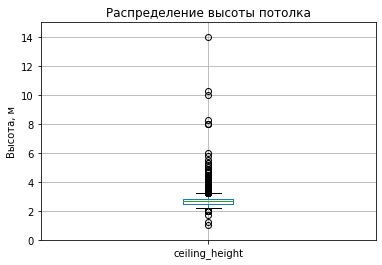

In [28]:
### building the box plot diagramm to check abnormalities in ceiling_height data
plt.ylim(0,15)
data.boxplot(column='ceiling_height')
plt.title('Распределение высоты потолка')
plt.ylabel('Высота, м');

Мы видим, что присутствуют аномальные значения как сверху, так и снизу. Разумно принять, что все объекты, где потолок выше 5 метров или меньше 2 метров - странные. Для того, чтобы понять, можем ли мы от таких данных избавиться. Оченим количество подобных вариантов:

In [29]:
print(len(data.query('ceiling_height > 5')) + len(data.query('ceiling_height < 2')))

16


Количество подобных объектов очень невелико и мы можем их отбросить со спокойной душой:

In [30]:
### looking for the indexes in the dataframe to delete based on condition
to_drop = data.loc[(data['ceiling_height'] > 5) | (data['ceiling_height'] < 2)].index

In [31]:
### droping the found data
data.drop(to_drop , inplace=True)

##### Столбец 'rooms'

В данном столбце присутствуют объекты с 0 количеством комнат:

In [32]:
### checking how many rows with 0 rooms in the dataset
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.0,2017-03-30T00:00:00,0,NaN,24.0,15.50,2,False,...,5.50,2.0,Мурино,NaN,NaN,0.0,NaN,0.0,NaN,181.0
349,4,2320000.0,25.0,2017-09-27T00:00:00,0,NaN,14.0,17.00,1,False,...,5.00,0.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,45.0
508,0,3375000.0,34.4,2017-03-28T00:00:00,0,NaN,26.0,24.30,19,False,...,8.70,1.0,Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.0,2019-02-20T00:00:00,0,NaN,10.0,17.00,7,False,...,5.00,0.0,Шушары,NaN,NaN,0.0,NaN,0.0,NaN,29.0
716,5,1500000.0,17.0,2017-06-07T00:00:00,0,2.7,9.0,12.00,1,False,...,3.00,0.0,Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22877,2,4280000.0,28.0,2017-10-26T00:00:00,0,2.7,19.0,18.00,10,False,...,6.00,0.0,Санкт-Петербург,18982.0,7206.0,0.0,NaN,1.0,415.0,151.0
23210,7,3200000.0,26.0,2017-09-01T00:00:00,0,NaN,25.0,18.00,16,False,...,5.00,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23554,15,3350000.0,26.0,2018-09-07T00:00:00,0,NaN,19.0,17.38,8,False,...,5.00,0.0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.0,2017-11-11T00:00:00,0,NaN,9.0,18.00,8,False,...,6.55,2.0,Никольское,NaN,NaN,0.0,NaN,0.0,NaN,82.0


Это может быть только если данный объект - апартаменты. Для других объектов, необходимо исправить эти данные и сделать количество комнат равными 1 как минимум.

In [33]:
### if we have 0 rooms in the row and this is not an apartment - replacing 0 rooms to 1
data.loc[(data['rooms'] == 0) & (data['is_apartment'] == False), 'rooms'] = 1

##### Столбец 'last_price'

Так как анализ недвижимости в любом случае делается для того, чтобы посмотреть что влияет на её цену, то важно правильно проанализировать цену объекта на момент снятия с публикации. Чтобы убрать объекты с аномальной ценой и оставить усреднённые. Посмотрим на начальные данные:

In [34]:
### checking the description of the data to have the general overview
data['last_price'].describe()

count    2.327400e+04
mean     6.471768e+06
std      1.056684e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.768348e+06
max      7.630000e+08
Name: last_price, dtype: float64

Видно, что что-то не то...Максимальные значения отличаются на 2 порядка от усреднённых. Визуализируем выведя гистаграмму:

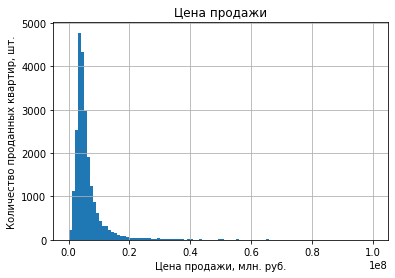

In [35]:
### building the histagramm to visualize the data
data['last_price'].hist(range = (0, 100000000), bins = 100)
plt.title('Цена продажи')
plt.ylabel('Количество проданных квартир, шт.')
plt.xlabel('Цена продажи, млн. руб.');

В процессе построения гистограммы стало понятно, что если диапазон необходимо указывать в 100 миллионов, то это многовато для обычной квартиры. Основная масса данных лежит от 0, до 40 миллионов. Посмотрим диаграмму размаха, чтобы определить, где у нас точно вбросы и от чего необходимо избавиться.

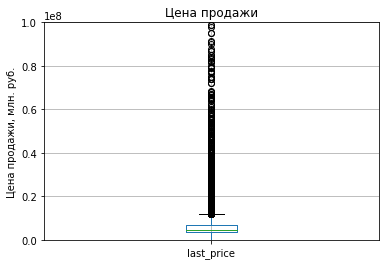

In [36]:
### building the box plot for last_price column to look for abnormal data
plt.ylim(-100,100000000)
data.boxplot(column='last_price')
plt.title('Цена продажи')
plt.ylabel('Цена продажи, млн. руб.');

Видно, что у нас есть достаточно много вбросов. Один из них - очень сильный. Однако не очень красивая картинка получилась. Так что поиграем с параметрами диаграммы для более красивой визуализации:

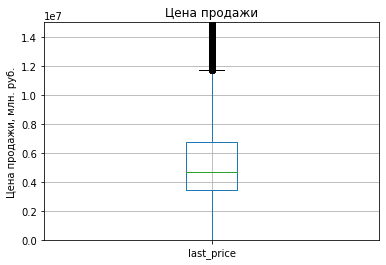

In [37]:
### tuning the box plot diagramm for better view
plt.ylim(-100,15000000)
data.boxplot(column='last_price')
plt.title('Цена продажи')
plt.ylabel('Цена продажи, млн. руб.');

Видно, что все объекты с ценой более 12000000 относятся к вбросам. Однако хочется оценить, сколько данных мы потенциально хотим отбросить. Для этого сделаем выборку из датасета и оценим её:

In [38]:
### checking how many rows we have with last_price above 12 mln
len(data.query('last_price > 12000000'))

1869

Таких объектов у нас около 2000 или почти 10% датасета. Отбрасывать их было бы неразумно. Предлагаю предположить, что стоимость объекта недвижимости более 25000000 рублей уже может считаться слишком высокой для обыкновенного жилья данного региона и мы можем отановиться на этом пределе. Уберем выбросы:

In [39]:
### removing all the rows where last_price is above 25 mln to get rid of abnormalities
data = data.query('last_price < 25000000')

Да, еще безусловно остались выбросы, но их следует оставить. Вообще, по хорошему, датасет можно было бы разделить на несколько и провести анализ каждого сегмента отдельно. Например разделить жильё на стандартное, бизнес класс и элитное. Разбить по диапазонам от 0 до 15000000, от 15000000 до 50000000 и от 50000000 и выше. Тогда мы получили бы более выверенные данные. Однако с тем единым датасетом, что есть у  нас, я считаю, что мы достигли результата по балансу наличия аномальных данных и репрезентативности выборки.

##### Столбец 'airports_nearest'

Проверим описание данных:

In [40]:
### describing the data
data['airports_nearest'].describe()

count    17409.000000
mean     28839.163306
std      12764.060038
min          0.000000
25%      18428.000000
50%      26831.000000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Мы видим минимальное значение удаления от аэропорта равное 0 для каких-то объектов. Это ошибка в данных, так как недвижимость не может находиться в аэропорту. Для начала посмотрим, сколько таких объектов:

In [41]:
### checking how many objects are literally inside the airport
data.query('airports_nearest == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000.0,34.7,2018-09-23T00:00:00,1,2.7,9.0,19.8,3,False,...,6.0,2.0,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


Всего один. Его стоит удалить.

In [42]:
### removing the wrong item
data = data.query('airports_nearest != 0')

#### Изменяем типы данных в столбцах:

##### Столбец 'first_day_exposition'

Данный столбец содержит изначально строковое значение дня, когда объект был выствлен на продажу. Необходимо привести его к виду даты и отбросить лишнее:

In [43]:
### changing the type of the data in the first_day_exposition column to the correct one
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,False,...,9.1,0.0,Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0


Теперь данные по дате размещения объекта выглядят корректно.

##### Столбец 'floors_total'

Необходимо привести данные к числовому типу без плавающей запятой, так как общее количество этажей не может быть дробным.

In [44]:
### changing float64 to int64 via .astype method
data['floors_total'] = data['floors_total'].astype('Int64')

##### Столбец 'balcony'

Посмотрим на тип данных в столбце 'balcony':

In [45]:
data['balcony'].dtype

dtype('float64')

Это странно, так как не бывает 1,5 балкона, равно так же как и 1,5 землекопа...Приведём данные к более подходящему целочисленному типу:

In [46]:
data['balcony'] = data['balcony'].astype('int64')

Проверим, что всё получилось:

In [47]:
data['balcony'].dtype

dtype('int64')

### Посчитайте и добавьте в таблицу новые столбцы

#### Добавляем столбец 'meter_price' - цена одного квадратного метра

In [48]:
### adding a new column as the result of the devision of the selling price by total area of the object
data['meter_price'] = data['last_price'] / data['total_area']
### rounding the resulted series to the comvenient state 
data['meter_price'] = data['meter_price'].round(decimals=1)

#### Добавляем столбец 'pub_week_day' - день публикации объявления

Здесь надо пояснить, что:
 - 0 - это понедельник
 - 1 - это вторник
 - 2 - это среда
 - 3 - это четверг
 - 4 - это пятница
 - 5 - это суббота
 - 6 - это воскресенье

In [49]:
### using the .weekday attribute of the DatetimeIndex class. It will give you exactly what you need.
data['pub_week_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

#### Добавляем столбец 'pub_month' - месяц публикации объявления

In [50]:
### using the .month attribute of the DatetimeIndex class. It will give you exactly what you need.
data['pub_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#### Добавляем столбец 'pub_year' - год публикации объявления

In [51]:
### using the .year attribute of the DatetimeIndex class. It will give you exactly what you need.
data['pub_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#### Добавляем столбец 'floor_type' - тип этажа квартиры

Данный столбец может принимать следующие значения:
- «первый» - если это первый этаж 
- «последний» - если это последний этаж
- «другой» - если это любой другой этаж

In [52]:
data.loc[data['floor'] == 1]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,pub_week_day,pub_month,pub_year
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.8,1,12,2018
14,1,4400000.0,36.0,2016-06-23,1,NaN,6,17.0,1,False,...,30759.0,0.0,NaN,1.0,96.0,203.0,122222.2,3,6,2016
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,10698.0,3.0,420.0,0.0,NaN,397.0,81707.3,3,11,2017
24,8,6500000.0,97.2,2015-10-31,2,NaN,3,46.5,1,False,...,2336.0,3.0,411.0,3.0,124.0,265.0,66872.4,5,10,2015
28,8,4170000.0,44.0,2017-12-13,1,2.90,6,20.8,1,False,...,30710.0,0.0,NaN,1.0,118.0,74.0,94772.7,2,12,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23665,11,4250000.0,47.0,2016-05-20,1,NaN,6,18.2,1,False,...,4946.0,2.0,624.0,1.0,519.0,131.0,90425.5,4,5,2016
23673,9,3100000.0,23.0,2018-03-19,1,2.80,9,12.6,1,False,...,11881.0,1.0,262.0,1.0,442.0,41.0,134782.6,0,3,2018
23680,14,5000000.0,59.0,2019-04-04,3,2.50,5,52.0,1,False,...,11878.0,0.0,NaN,0.0,NaN,NaN,84745.8,3,4,2019
23696,18,2500000.0,56.7,2018-02-11,2,NaN,3,29.7,1,False,...,NaN,0.0,NaN,0.0,NaN,NaN,44091.7,6,2,2018


In [53]:
### filling the 'floor_type' column with relevant data for rows where 'floor' = 1
data.loc[data['floor'] == 1 , 'floor_type'] = 'первый'

In [54]:
### filling the 'floor_type' column with relevant data for rows where 'floor' value equals 'floors_total' value
### when floor and floors_total equal 1 it will be stll "first" or 'первый'
data.loc[(data['floor'] == data['floors_total']) & (data['floors_total'] != 1) , 'floor_type'] = 'последний'

In [55]:
### all other 'floor_type' rows are filled with the third value
data['floor_type'].fillna('другой', inplace=True)

#### Добавляем столбец 'cityCenters_nearest_km' - расстояние до центра города в километрах

In [56]:
### adding the necessary row by dividing 'cityCenters_nearest' data (in meters) by 1000 and rounding.
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

In [57]:
### changing the type of the data from float to int. Because it was reounded in the previous step.
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('Int64')

### Проведите исследовательский анализ данных

#### Изучим параметры объектов:

##### Общая площадь

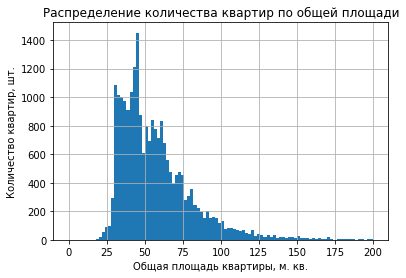

In [58]:
### building the histagramm to see the total_area distribution
data['total_area'].hist(bins=100, range = (0, 200))
plt.title('Распределение количества квартир по общей площади')
plt.xlabel('Общая площадь квартиры, м. кв.')
plt.ylabel('Количество квартир, шт.');

In [59]:
### describing the data
data['total_area'].describe()

count    22813.000000
mean        57.562918
std         26.070659
min         14.000000
25%         40.000000
50%         51.300000
75%         68.000000
max        460.800000
Name: total_area, dtype: float64

Можно сказать, что для общей площади объектов мы наблюдаем 2 пика - на площади от 25 до 48 метров и на площади от 50 до 70 метров. Это более менее адекватные данные для квартир, начиная от малогабаритных и заканчивая обычными трехкомнатными. Средняя общая площадь объектов составила 57,5 метра, что похоже на реальность.

##### Жилая площадь

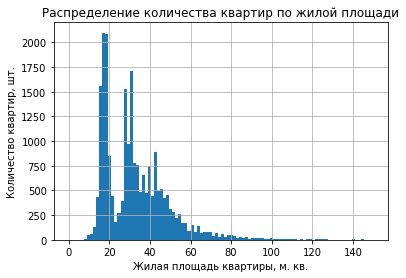

In [60]:
### building the histagramm to see the living_area distribution
data['living_area'].hist(bins=100, range = (0, 150))
plt.title('Распределение количества квартир по жилой площади')
plt.xlabel('Жилая площадь квартиры, м. кв.')
plt.ylabel('Количество квартир, шт.');

In [61]:
### describing the data
data['living_area'].describe()

count    22813.000000
mean        33.052878
std         17.436499
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        279.600000
Name: living_area, dtype: float64

Можно сказать, что для общей жилой площади мы наблюдаем 3 пика - на площади около 20 метров, на площади около 30 метров и на площади около 45 метров. В выборке присуствуют объекты с очень маленькой жилой площадью, но при этом их общая площадь - адекватна. Возможно это особенности данных, но я бы не назвал их аномальними. Возможно это особенность регистрации недвижимости.

In [62]:
### checking the data with very small living area to see how valid they are
data.query('0 < living_area < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,pub_week_day,pub_month,pub_year,floor_type,cityCenters_nearest_km
114,5,4000000.0,21.40,2019-02-07,1,2.90,8,8.3,7,False,...,488.0,1.0,286.0,NaN,186915.9,3,2,2019,другой,6
680,14,7200000.0,43.00,2017-10-31,1,NaN,8,9.0,2,False,...,2137.0,1.0,933.0,296.0,167441.9,1,10,2017,другой,5
1326,8,8100000.0,52.00,2017-01-29,2,2.70,25,9.0,15,False,...,NaN,1.0,1180.0,337.0,155769.2,6,1,2017,другой,16
2309,10,4200000.0,62.40,2017-06-15,2,2.60,9,8.4,6,False,...,NaN,0.0,NaN,111.0,67307.7,3,6,2017,другой,29
3242,7,4440000.0,41.00,2017-07-02,1,NaN,17,3.0,17,False,...,NaN,0.0,NaN,216.0,108292.7,6,7,2017,последний,13
4100,17,5300000.0,34.80,2017-06-19,1,2.70,23,9.0,15,False,...,NaN,0.0,NaN,30.0,152298.9,0,6,2017,другой,13
4542,12,3300000.0,18.00,2018-11-07,1,3.50,5,9.0,2,False,...,349.0,1.0,963.0,9.0,183333.3,2,11,2018,другой,5
7312,8,3400000.0,27.00,2018-02-21,2,2.50,15,9.0,4,False,...,617.0,0.0,NaN,NaN,125925.9,2,2,2018,другой,16
8325,9,4800000.0,52.00,2017-10-25,2,NaN,5,9.0,2,False,...,NaN,2.0,118.0,119.0,92307.7,2,10,2017,другой,13
13915,20,6350000.0,52.00,2018-02-06,2,3.00,6,2.0,2,False,...,NaN,1.0,1012.0,91.0,122115.4,1,2,2018,другой,7


##### Площадь кухни

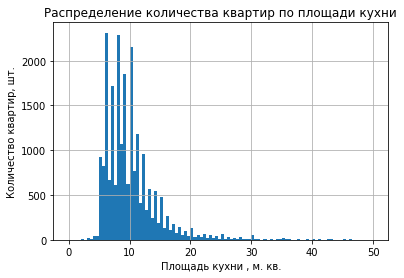

In [63]:
### building the histagramm to see the kitchen_area distribution
data['kitchen_area'].hist(bins=100, range=(0,50))
plt.title('Распределение количества квартир по площади кухни')
plt.xlabel('Площадь кухни , м. кв.')
plt.ylabel('Количество квартир, шт.');

In [64]:
### describing the data
data['kitchen_area'].describe()

count    22813.000000
mean        10.106970
std          4.864091
min          1.300000
25%          7.000000
50%          9.000000
75%         11.470000
max        100.700000
Name: kitchen_area, dtype: float64

Для площадь кухонь у нас получилась небольшая "гребёнка" так как чаще всего она меняется не плавно вместе с размером жилья, а скачками. Хотя это может быть и результат заполнения пропусков в данных. Есть очень маленькие кухни (до 5 м.кв), но это особенность жилого фонда и таких значений достаточно мало. В целом распределение следует за общей площадью недвижимости и повторяет его.

##### Цена объекта

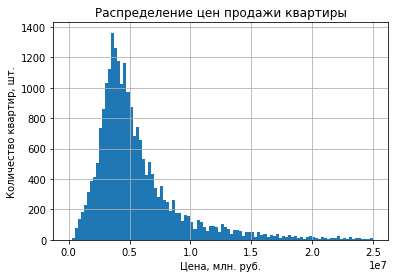

In [65]:
### building the histagramm to see the last_price distribution
data['last_price'].hist(bins=100, range=(0, 25000000))
plt.title('Распределение цен продажи квартиры')
plt.xlabel('Цена, млн. руб.')
plt.ylabel('Количество квартир, шт.');

In [66]:
### describing the data
data['last_price'].describe()

count    2.281300e+04
mean     5.577832e+06
std      3.572206e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.550000e+06
max      2.490000e+07
Name: last_price, dtype: float64

Ограничив максимальную цену 25 млн. мы получили хорошее распределение цен с одним пиком около 4 млн., что разумно. В целом, можно сказать, что обладая средствами в размете 6 млн. можно позволить себе выбирать недвижимость очень придирчево, так как вариантов в такой бюджет множество.

##### Количество комнат

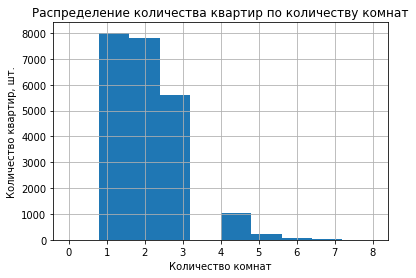

In [67]:
### building the histagramm to see the rooms distribution
data['rooms'].hist(bins=10, range=(0,8))
plt.title('Распределение количества квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир, шт.');

In [68]:
### describing the data
data['rooms'].describe()

count    22813.000000
mean         2.039232
std          0.989997
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

Основную массу выборки составляют объекты с 1 - 3 комнатами. Объектов с 0 комнат не осталось, так как на этапе предварительного анализа выяснили, что все такие объекты не апартаменты и поэтому не могут иметь 0 комнат. Данное распределение коррелирует с эмпирическими данными о том, что на рынке всегда больше всего 1 и 2-х комнатных квартир.

##### Высота потолков

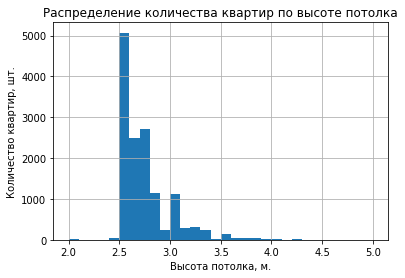

In [69]:
### building the histagramm to see the ceiling_height distribution
data['ceiling_height'].hist(bins=30, range=(2,5))
plt.title('Распределение количества квартир по высоте потолка')
plt.xlabel('Высота потолка, м.')
plt.ylabel('Количество квартир, шт.');

In [70]:
### describing the data
data['ceiling_height'].describe()

count    14040.000000
mean         2.712692
std          0.257111
min          2.000000
25%          2.500000
50%          2.650000
75%          2.800000
max          5.000000
Name: ceiling_height, dtype: float64

К сожалению, данные по высоте потолков у нас есть не по всем объектам и мы при подготовке данных также удалили объекты с аномальными значениями (вроде потолков менее 2-х метров или более 5 метров). Однако мы можем сказать, что основная масса объектов имеет потолки около 2,5 - 2,6 метров, что более менее коррелирует с реальностью. Воторой пик приходится на объекты с потолками около 3-х метров, но такие встречаются не очень часто. 
Также мы можем видить, что стандартное отклонение данных небольшое и близко к ожидаемым значениям.

##### Этаж квартиры

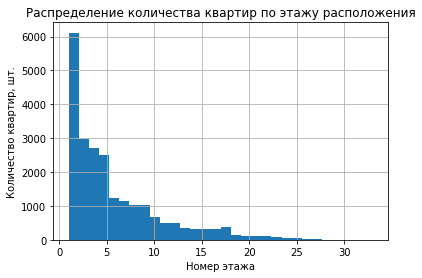

In [71]:
### building the histagramm to see the floor distribution
data['floor'].hist(bins=30)
plt.title('Распределение количества квартир по этажу расположения')
plt.xlabel('Номер этажа')
plt.ylabel('Количество квартир, шт.');

In [72]:
### describing the data
data['floor'].describe()

count    22813.000000
mean         5.861745
std          4.870198
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Мы видим, что у нас много объектов расположено на 1-ых и 2-ых этажах. Видимо людям не нравится жить низко и они стараются продать такую недвижимость. Также судя по описанию данных столбца подавляющее большинство квартир расположено до 9-го этажа. Можно предположить, что это старый жилой фонд 5,9 или 11-ти этажек (в основном 5-ти судя по квартилям), что объясняет и маленькие кухни и низкие потолки и небольшую жилую и общую площадь.

##### Тип этажа квартиры

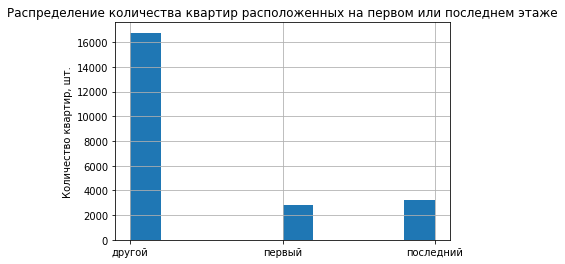

In [73]:
### building the histagramm to see the floor_type distribution
data['floor_type'].hist(bins=10)
plt.title('Распределение количества квартир расположенных на первом или последнем этаже')
plt.ylabel('Количество квартир, шт.');

Здесь, в целом, добавить нечего. Большинство объектов расположены между первым и последним этажами. Это очевидно.

##### Общее количество этажей в доме

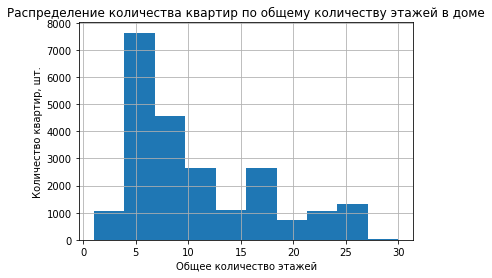

In [74]:
### building the histagramm to see the floors_total distribution
data['floors_total'].hist(bins=10, range=(1,30))
plt.title('Распределение количества квартир по общему количеству этажей в доме')
plt.xlabel('Общее количество этажей')
plt.ylabel('Количество квартир, шт.');

In [75]:
### describing the data
data['floors_total'].describe()

count    22813.000000
mean        10.675185
std          6.598221
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Подтверждается вывод, что множество объектов недвижимости у нас находятся в старом жилом фонде в 5-ти этажках или 9-11-ти этажках со всеми особенностями подобного жилья, так как квартиры в подобных домах строились до современных стандартов по комфортноcти. 

##### Расстояние до центра города в метрах

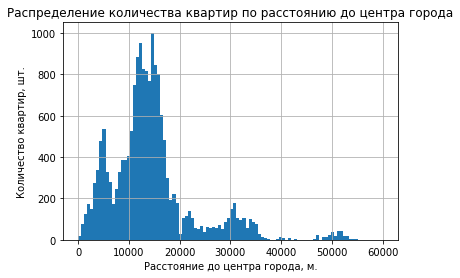

In [76]:
### building the histagramm to see the cityCenters_nearest distribution
data['cityCenters_nearest'].hist(bins=100, range=(0,60000))
plt.title('Распределение количества квартир по расстоянию до центра города')
plt.xlabel('Расстояние до центра города, м.')
plt.ylabel('Количество квартир, шт.');

In [77]:
### describing the data
data['cityCenters_nearest'].describe()

count    17426.000000
mean     14427.294043
std       8599.737183
min        208.000000
25%       9706.000000
50%      13242.000000
75%      16412.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

К сожалению, данные по расстоянию до центра у нас доступны не для всех объектов. Но можно выделить 4 пика объектов - около 5 км до центра города, около 12-15 километров до центра города, около 30 км до центра и отдельный небольшой пик в районе 50 - 52 км. Скорее всего объекты первых двух пиков принадлежат либо городу, либо пригороду, а вот вторые 2 пика - уже сельская местность. В целом можно судить, что выборка состоит из объектов относящихся к городу.

##### Расстояние до ближайшего аэропорта

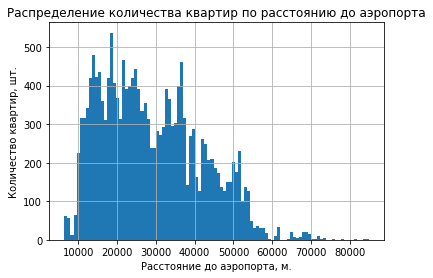

In [78]:
### building the histagramm to see the airports_nearest distribution
data['airports_nearest'].hist(bins=100)
plt.title('Распределение количества квартир по расстоянию до аэропорта')
plt.xlabel('Расстояние до аэропорта, м.')
plt.ylabel('Количество квартир, шт.');

In [79]:
### describing the data
data['airports_nearest'].describe()

count    17408.000000
mean     28840.819968
std      12762.554836
min       6450.000000
25%      18428.000000
50%      26831.000000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Здесь распределение данных тоже кажется более менее адекватным. Ближайший объект находится в 6 км от аэропорта, а самый удалённый на расстоянии около 85 км. 

##### Расстояние до ближайшего парка

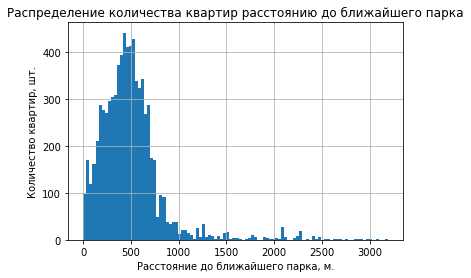

In [80]:
### building the histagramm to see the parks_nearest distribution
data['parks_nearest'].hist(bins=100)
plt.title('Распределение количества квартир расстоянию до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м.')
plt.ylabel('Количество квартир, шт.');

In [81]:
### describing the data
data['parks_nearest'].describe()

count    7617.000000
mean      493.317973
std       340.753390
min         1.000000
25%       290.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

По полученным данным (хотя они есть далеко не для всех объектов) можно увидеть, что большая часть объектов, которые указали расстояние до парка находятся не очень далеко от них. Плюс минус 500 метров. Минимальное значение в 1 метр я не считаю аномальним так как парком можно считать и большой зелёный двор. В целом данные более менее совпадают с реальностью.

##### День и месяц публикации объявления

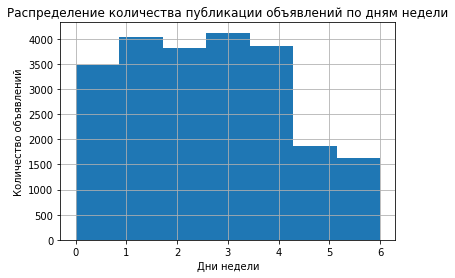

In [82]:
### building the histagramm to see the pub_week_day distribution
data['pub_week_day'].hist(bins=7, range=(0,6))
plt.title('Распределение количества публикации объявлений по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество объявлений');

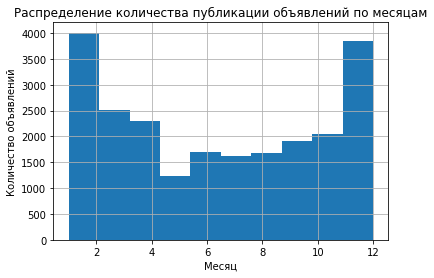

In [83]:
### building the histagramm to see the pub_month distribution
data['pub_month'].hist(bins=10, range=(1,12))
plt.title('Распределение количества публикации объявлений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество объявлений');

По этим данным можно сказать, что размещение объявлений носит сезонный характер с пиками в декабре и январе и постепенно снижается к лету. Так что если вы хотите меньше конкуренции, то лучше это учитывать. Интересно было бы сравнить это с данными по поисковым запросам или заходу на сайты. Чтобы понять совпадает ли предложение со спросом. По дням недели все стабильно - в основном объявления размещаются на буднях и почти в 2 раза меньше на выходных.

#### Оценим скорость продажи квартиры:

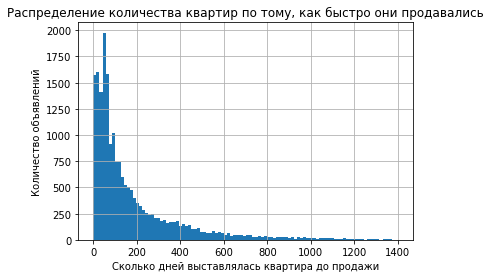

In [84]:
### building the histagramm to see the days_exposition distribution
data['days_exposition'].hist(bins=100, range=(0, 1400))
plt.title('Распределение количества квартир по тому, как быстро они продавались')
plt.xlabel('Сколько дней выставлялась квартира до продажи')
plt.ylabel('Количество объявлений');

In [85]:
### describing the data
data['days_exposition'].describe()

count    19785.000000
mean       178.968410
std        217.187349
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

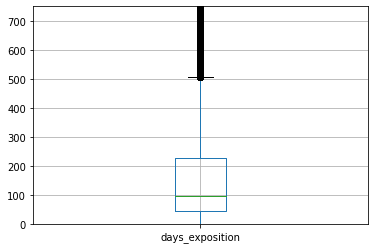

In [86]:
### box plot diagramm for days_exposition
plt.ylim(0,750)
data.boxplot(column='days_exposition');

Кажется, что в среднем, объект продаётся где-то за 179 дней, но если мы нивелируем влияние нехарактерных объектов, которые по какой-то причине продаются очень долго, то можно сказать что в целом реально продать адекватный объект за 100 дней, то есть около 3-х месяцев. Быстрыми можно считать продажи за 1 - 1,5 месяца, а необычно долгими все те, что продаются более 500 дней, то есть почти 1,5 года.
Также есть объекты рекордсмены, кототрые с одной стороны были проданы за 1 день, так и те, которые продавались более 4-х лет.

#### Факторы больше всего влияюшие на общую (полную) стоимость объекта:

##### Общая площадь, жидая площадь, площадь кухни, количество комнат и этаж объекта

Изучим для начала, зависит ли цена от:

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);

Для этого подготовим выборку из изначального датасета с необходимыми данными:

In [87]:
### preparing the subset of the main dataset with necessary data for analisys
data_to_analyse = data[['total_area','living_area','kitchen_area','rooms','floor_type','last_price']]

Построим диаграмму рассеяния для полученного нового датасета, чтобы оценить влияние выбранных данных на цену параметров. Также применим параметр полупрозрацности для визуализации сосредоточения однородных данных:

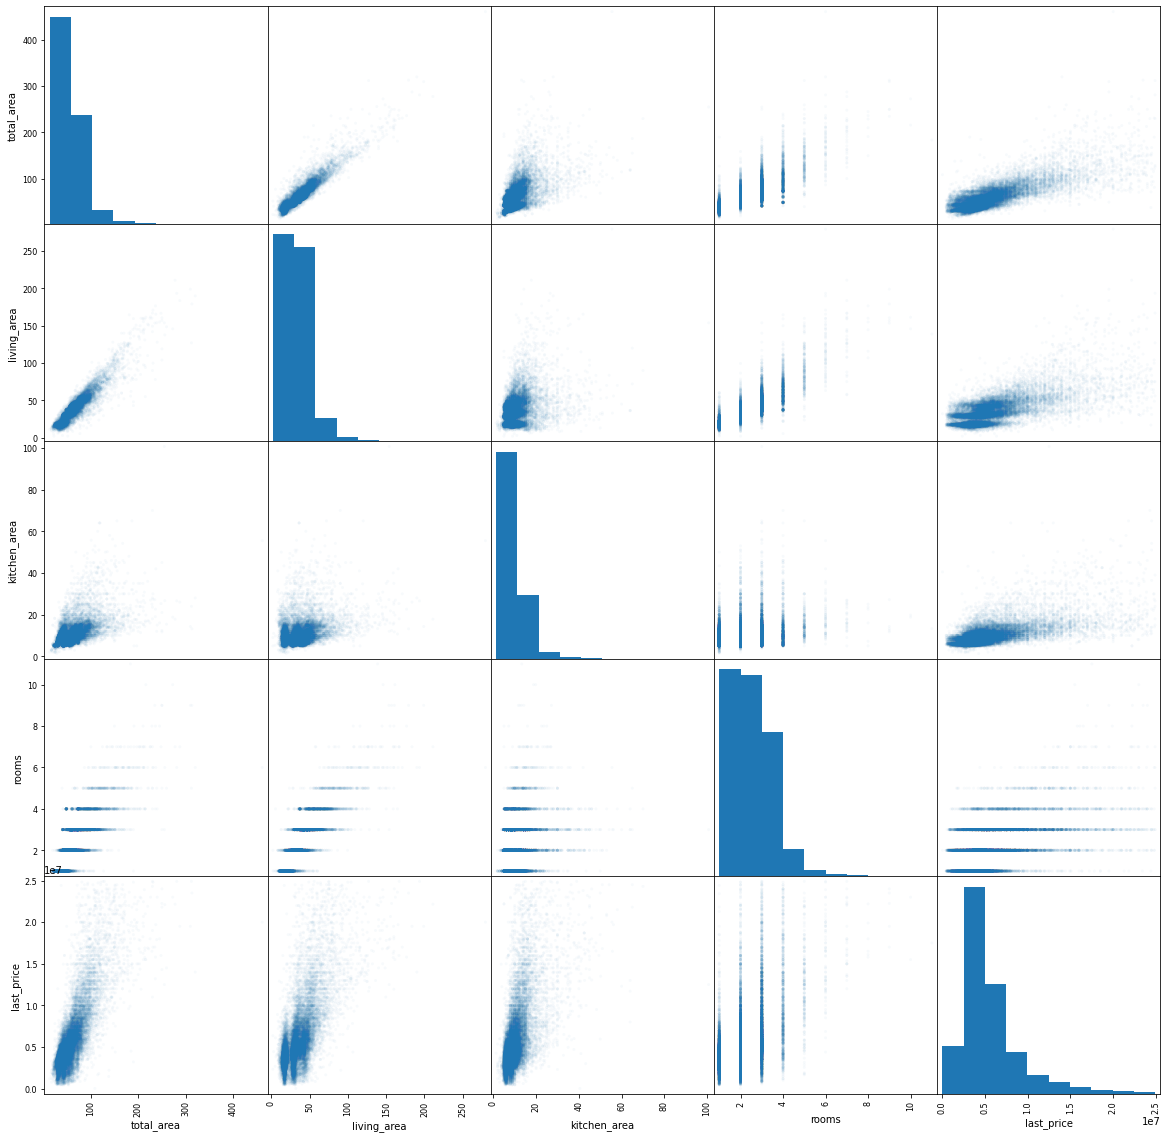

In [88]:
### preparing the scatterplot for the subset
pd.plotting.scatter_matrix(data_to_analyse, figsize=(20, 20), alpha=0.03);

Теперь самое время взглянуть на матрицу корреляции:

In [89]:
### let's see the correlation between the data in the subset
data_to_analyse.corr()

,total_area,living_area,kitchen_area,rooms,last_price
total_area,1.000000,0.932758,0.558786,0.797871,0.781009
living_area,0.932758,1.000000,0.343944,0.872787,0.680843
kitchen_area,0.558786,0.343944,1.000000,0.210960,0.591676
rooms,0.797871,0.872787,0.210960,1.000000,0.516496
last_price,0.781009,0.680843,0.591676,0.516496,1.000000


Из этого следует вполне очевидный вывод - да, стоимость жилья напрямую связана с общей, жилой площадью и площадью кухни. На это указывают как графики, так и корреляция, которая положительная. Особо сильное влияние оказывает общая площадь жилья и его жилая площадь так как это всегда самые основные параметры на которые обращают внимание покупатели или продавцы при выставлении цены.

##### Время размещения объявления в базе

Теперь проанализируем зависимость цены продажи от времени размещения обявления. Посомотрим зависит ли она от года, месяца или дня недели. Для этого, опять же, воспользуемся дополнительным датасетом для удобства:

In [90]:
### creating new temporary dataset for analisys
data_to_analyse_2 = data[['pub_week_day','pub_month','pub_year','last_price']]

Посмотрим на корреляцию цены продажи объекта от года, месяца или дня недели:

In [91]:
### checking the correlation between data
data_to_analyse_2.corr()

,pub_week_day,pub_month,pub_year,last_price
pub_week_day,1.000000,0.011190,-0.002422,-0.016116
pub_month,0.011190,1.000000,-0.271624,0.000221
pub_year,-0.002422,-0.271624,1.000000,-0.029056
last_price,-0.016116,0.000221,-0.029056,1.000000


Как мы видим, корреляции нет. Либо она ничтожна. Однако можно продолжить искать зависимости. Например попробуем построить диаграмму зависимости усреднённой стоимости проданного объекта от года размещения объявления и график общего количества проданных объектов по годам. Так как мы знаем, что время продажи может составлять до полугода, то учтём это: 

In [92]:
### building the pivot table to median of the total sum of all sold items 
### by the year when this item was announced on the market.
year_analisys = data.pivot_table(index='pub_year', values='last_price', aggfunc='median')

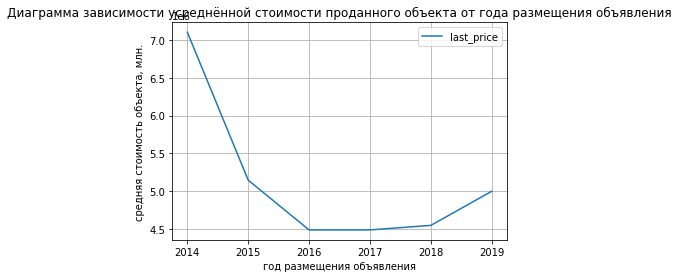

In [93]:
### building the plot diagramm
year_analisys.plot(grid=True, xlabel='год размещения объявления', ylabel='средняя стоимость объекта, млн.', title='Диаграмма зависимости усреднённой стоимости проданного объекта от года размещения объявления');

In [94]:
### new pivot table to check how many objects were sold each year
year_analisys = data.pivot_table(index='pub_year', values='last_price', aggfunc='count')
print (year_analisys)

          last_price
pub_year            
2014             121
2015            1102
2016            2662
2017            7915
2018            8232
2019            2781


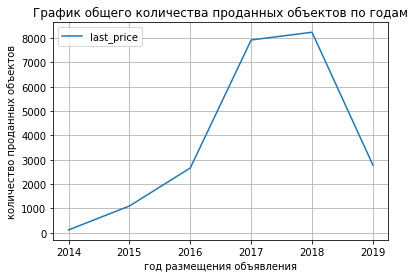

In [95]:
### visualizing the data
year_analisys.plot(grid=True, xlabel='год размещения объявления', ylabel='количество проданных объектов', title='График общего количества проданных объектов по годам');

Из данного графика можно сделать вывод, что после 2014 года люди перестали покупать дорогие объекты, однако на рынок вышла большая масса людей с небольшими накоплениями, которые хотели как-то их сберечь от неопределёности и они поспешили вложить их в любою доступную недвижимость. То есть если ранее покупали "для себя и надолго", то после 2014 стали покупать в качестве инвестиции и все, что было на рынке. 

In [96]:
#grouping to analyze price
review_code = data.groupby('pub_year').agg({'last_price': ['count','mean','median']})

Text(0, 0.5, 'медианная цена проданного объекта, млн. руб')

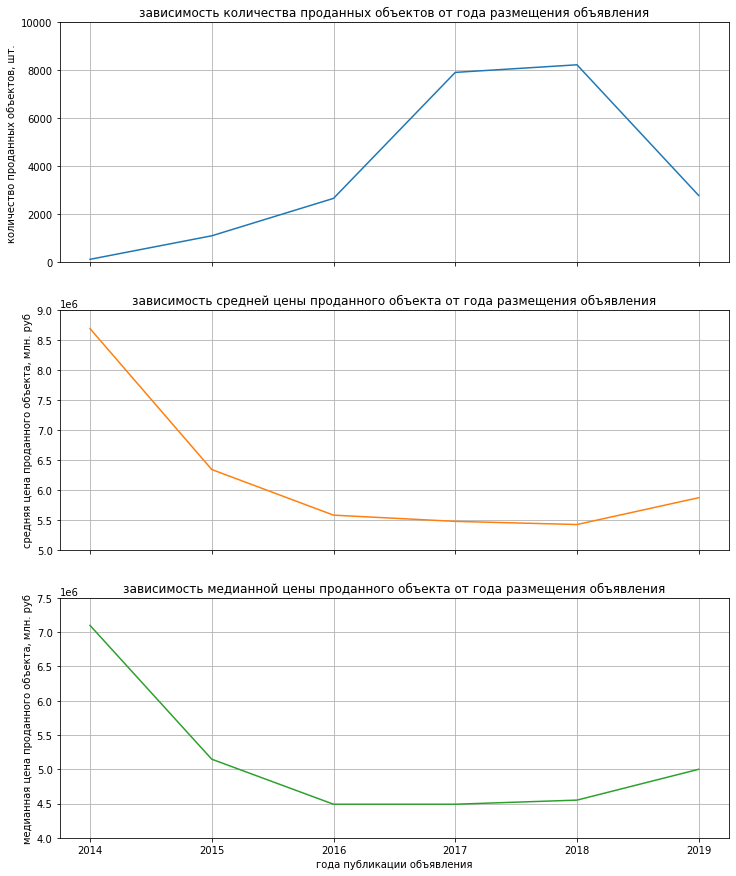

In [97]:
### building subplots for amount, mean price and median and tuning the plots
axes = review_code.plot(grid=True, subplots=1, figsize=(12,15), xlabel='года публикации объявления', legend=False)
axes[0].set_title('зависимость количества проданных объектов от года размещения объявления')
axes[0].set_ybound(0, 10000)
axes[0].set_ylabel('количество проданных объектов, шт.')
axes[1].set_title('зависимость средней цены проданного объекта от года размещения объявления')
axes[1].set_ybound(5000000, 9000000)
axes[1].set_ylabel('средняя цена проданного объекта, млн. руб')
axes[2].set_title('зависимость медианной цены проданного объекта от года размещения объявления')
axes[2].set_ybound(4000000, 7500000)
axes[2].set_ylabel('медианная цена проданного объекта, млн. руб')

In [98]:
#resulting table
data.groupby('pub_year').agg({'last_price': ['count','mean','median']})
data.pivot_table(columns='pub_year',values='last_price',aggfunc=('count','mean','median'))

pub_year,2014,2015,2016,2017,2018,2019
count,1.210000e+02,1.102000e+03,2.662000e+03,7.915000e+03,8.232000e+03,2.781000e+03
mean,8.693002e+06,6.342464e+06,5.581497e+06,5.477768e+06,5.425173e+06,5.872468e+06
median,7.100000e+06,5.147000e+06,4.490000e+06,4.490000e+06,4.550000e+06,5.000000e+06


#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:

Попробуем посчитать среднюю цену квадратного метра для тех мест, где объявлений больше всего. Для этого, для начала, отсортируем первоначальный датасет и посморим на первые 10 значений:

In [99]:
### looking for top 10 places by number of objects
top_10 = data['locality_name'].value_counts().head(10)
top_10

Санкт-Петербург    15014
Мурино               544
Кудрово              449
Шушары               439
Всеволожск           396
Пушкин               360
Колпино              336
Парголово            326
Гатчина              307
Выборг               237
Name: locality_name, dtype: int64

Далее пробежимся по основному датасету выделяя значения с городом из топ-10 и посчитаем среднюю стоимость квадратного метра жилья:

In [100]:
### Iterating through the main dataset, selecting rows with cities from top_10 and calculating the median rounding to
### approproate number
for item in top_10.index:
    number = data.loc[data['locality_name'] == item, 'meter_price'].median().round(decimals=1)
    print(f'Средняя стоимость квадратного метра жилья в {item} составляет {number} рублей')

Средняя стоимость квадратного метра жилья в Санкт-Петербург составляет 103765.3 рублей
Средняя стоимость квадратного метра жилья в Мурино составляет 85668.8 рублей
Средняя стоимость квадратного метра жилья в Кудрово составляет 95348.8 рублей
Средняя стоимость квадратного метра жилья в Шушары составляет 76829.3 рублей
Средняя стоимость квадратного метра жилья в Всеволожск составляет 65789.5 рублей
Средняя стоимость квадратного метра жилья в Пушкин составляет 99725.4 рублей
Средняя стоимость квадратного метра жилья в Колпино составляет 74689.8 рублей
Средняя стоимость квадратного метра жилья в Парголово составляет 91780.2 рублей
Средняя стоимость квадратного метра жилья в Гатчина составляет 67796.6 рублей
Средняя стоимость квадратного метра жилья в Выборг составляет 58158.3 рублей


По полученным данным можно сделать вывод, что из топ 10 городов с наибольшим количеством объявлений самым дорогим является, ожидаемо, Санкт-Петербург, а дешевле всего квадратный метр недвижимости стоит в Выборге. Почти в 2 раза дешевле, чем в северной столице.

#### Cредняя цена каждого километра удаления от центра для недвижимости Санкт-Петербурга и анализ зависимости стоимости объектов от расстояния до центра города.

Давайте оценим на имеющихся данных стоимость каждого километра удаления недвижимости от центра Санкт-Петербурга. Для этого соберём необходимые данные в отдельный датасет и сразу выкинем из него строки, где растояние до центра города 0 км, так как это явно ошибка:

In [101]:
### creating main dataset slice with necessary data removing abnormal rows
sp_data = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km != 0')

Вычисляем стоимость 1 километра пользуясь теми данными, которые у нас есть, то есть делим цену недвижимости на расстояние до центра в километрах:

In [102]:
### one km price is the devision of item selling price by the distance in km to the SPB city centre
sp_data['km_price'] = sp_data['last_price'] / sp_data['cityCenters_nearest_km']
warnings.filterwarnings("ignore")

Теперь приводим полученное значение от числа с плавающей запятой до обычного целого. Для удобства:

In [103]:
### changinh the type of the data to the appropriate one:
sp_data['km_price'] = sp_data['km_price'].astype('Int64')
warnings.filterwarnings("ignore")

Создаём пустой список, в который потом сложим среднее значение стоимости километра:

In [104]:
### creating empty list for the use later to store data 
result = []

Проходим циклом по данным в датафрейме выбирая в качестве условия отсортированный список уникальных значений расстояния от объекта до центра города. По всем совпадениям вычисляем медианное значение стоимости километра расстояния. Это нужно для того, чтобы усреднить стоимость с учетом выбросов, так как раазные объекты при одинаковом расстоянии стоят по разному.

In [105]:
### getting sorted list of the unique items in 'cityCenters_nearest_km' column and then iterating through them collecting
### values in 'km_price' column and adding median of the collected data to the result list
for item in sorted(sp_data['cityCenters_nearest_km'].unique()):
     result.append(sp_data.loc[sp_data['cityCenters_nearest_km'] == item, 'km_price'].median())

Генерируем датасет по полученным данным:

In [106]:
### creating the new dataset for the graphical results presentation
resulted_df = pd.DataFrame(result, columns=['km_price'])

Строим график медианной стоимости километра в зависимости от расстояния. Надо понимать, что для каждого расстояния до центра Санкт-Петербурга из основного датасета медиана своя. Построенная усредненем стоимости одного километра для объектов разной стоимости, но на одном расстоянии от центра:

<AxesSubplot:title={'center':'Зависимость цены километра от удаления от центра'}, xlabel='расстояние, км.', ylabel='стоимость, млн.'>

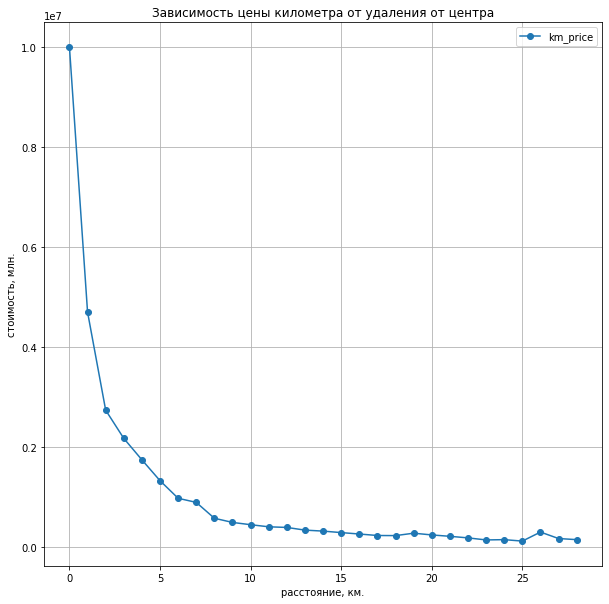

In [107]:
### making the plot to visualize the data
resulted_df.plot(title='Зависимость цены километра от удаления от центра', grid=True, figsize=(10,10), style='o-', \
                xlabel='расстояние, км.', ylabel='стоимость, млн.')

Можно сделать вывод, что зависимость стоимости километра удаления от центра для объектов меняется нелинейно. Например на расстоянии 5 километров стоимость километра уже почти в 5 раз меньше, чем для объектов в центре. Однако начиная с 13 километров стоимость каждого последующего километра удаления почти не меняется. Но это гипотетическая стоимость, так как объекты были сгруппированы по дальности от центра. Если же мы хотим оценить реальную усреднённую стоимость километра, то возмём медиану от уже полученных медиан: 

In [108]:
### calculating the median for the whole temporary dataset
resulted_df.median()

km_price    326666.0
dtype: float64

Так что можно сделать вывод, что в среднем каждый километр удаления от центра Санкт-Петербугра снижает стоимость недвижимости на 325 000 рублей.

In [109]:
### checking the slice from the dataset with the parameters below to check the hypotesys
data.query('cityCenters_nearest_km == 27').sort_values(by='last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,pub_week_day,pub_month,pub_year,floor_type,cityCenters_nearest_km
18386,15,24800000.0,190.00,2014-12-10,4,2.62,4,104.1,3,False,...,114.0,0.0,NaN,NaN,130526.3,2,12,2014,другой,27
140,8,16912000.0,105.70,2016-12-09,2,2.70,3,48.4,1,False,...,366.0,3.0,179.0,390.0,160000.0,4,12,2016,первый,27
7996,17,16600000.0,106.00,2017-12-02,4,3.20,3,50.0,3,False,...,254.0,0.0,NaN,NaN,156603.8,5,12,2017,последний,27
15578,20,16000000.0,101.90,2018-01-08,2,2.87,4,48.1,1,False,...,273.0,3.0,368.0,NaN,157016.7,0,1,2018,первый,27
12466,11,15000000.0,89.60,2017-01-31,3,NaN,3,57.0,3,False,...,317.0,3.0,509.0,357.0,167410.7,1,1,2017,последний,27
748,13,14350000.0,74.00,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.9,1,11,2017,другой,27
4400,4,12300000.0,78.65,2017-09-09,3,NaN,5,48.0,1,False,...,403.0,0.0,NaN,4.0,156389.1,5,9,2017,первый,27
2948,23,11350000.0,75.00,2017-08-15,3,3.50,2,52.7,2,False,...,216.0,3.0,153.0,207.0,151333.3,1,8,2017,последний,27
22037,15,10900000.0,145.00,2017-04-17,2,3.50,2,39.0,2,False,...,216.0,3.0,153.0,188.0,75172.4,0,4,2017,последний,27
2776,8,10500000.0,105.00,2017-12-06,4,3.12,3,76.3,1,False,...,169.0,0.0,NaN,NaN,100000.0,2,12,2017,первый,27


### Общий вывод

Проведена работа по подготовке данных для анализа в части устранения пропущенных данных. Не всё пропуски, к сожалению, удалось нивелировать, но оставшиеся не сильно влияют на качество анализа. Были выявлены дубликаты в назаниях населённых пунктов, которые также были устранены. Выбросы и нехарактерные данные были тоже обработаны и удалены те, которые не влияют на результаты анализа.
Проведённый исследовательский анализ данных подтвердил, что данные были очищенны корректно и позволил убедиться в том, что:

1. Срок, за котрый в среднем продаётся объект недвижимости составляет **от 3 до 5 месяцев**. Быстрыми можно считать продажи за 1 - 1,5 месяца, а необычно долгими те, что продаются более 1,5 лет. Если ваша недвижимость не продаётся более 5-6 месяцев, то, возможно стоит пересмотреть цену.
2. Стоимость недвижимости **больше всего зависит от общей площади объекта и его жилой площади**. В меньшей степени от количества комнат или размера кухни.
3. Основные объекты недвижимости это обкты ценой **до 10 миллионов рублей с общей площадью до 100 м2, жилой площадью до 50м2 и кухней до 20м2**.
4. Подавляющее большинство объектов недвижимости расположено до 9-го этажа. Также можно предположить, что это **старый жилой фонд 5,9 или 11-ти этажных зданий**.
5. Размещение объявлений **носит сезонный характер** и учащается зимой снижаясь до минимальных значений летом. В течении недели спад размещений приходит к выходным.
6. Стоимость квадратного метра жилья в **10 городах с самым большим количеством размещённых объявлений** составляет:

    - 103771.5 рублей для Санкт-Петербурга
    - 85657.1 рублей для Мурино
    - 95522.4 рублей для Кудрово
    - 76876.2 рублей для Шушар
    - 65789.5 рублей для Всеволожска
    - 99725.4 рублей для Пушкина
    - 74689.8 рублей для Колпина
    - 91780.2 рублей для Парголово
    - 67796.6 рублей для Гатчины
    - 58158.3 рублей для выборга


7. Среднее падение стоимости недвижимости при удалении от центра Санкт-Петербурга составляет **326666.0 рубля** за километр.
